## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  In this project, the intent was to understand the results of an A/B test run by an e-commerce website.  My goal was to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from patsy import dmatrices
import statsmodels.api as sm;
from statsmodels.stats.outliers_influence import variance_inflation_factor

%matplotlib inline

#We are setting the seed to assure we get the same answers always
random.seed(42)

C:\Users\Manju Goyal\Anaconda3\envs\dataanalysis\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


`1.` Now, let us read the `ab_data.csv` data. Store it in `df`. 

In [2]:
import pandas as pd
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Let us find the number of rows in the dataset.

In [3]:
len(df)

294478

Let us find number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

Let us compute the proportion of users converted.

In [5]:
df['converted'].mean()

0.11965919355605512

The number of times the `new_page` and `treatment` don't line up.

In [4]:
a = (df['landing_page'] == 'new_page').sum() + (df['group'] == 'treatment').sum()
b = len(df.query('landing_page == "new_page" & group == "treatment"'))
a -2*b

3893

 Do any of the rows have missing values?

In [5]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page. let us create a new dataset **df2**.

In [6]:
df_temp = df.query('landing_page == "new_page" & group == "treatment"')
df2 = df.query('landing_page == "old_page" & group == "control"')
df2 = df2.append(df_temp)

In [7]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

How many unique **user_id**s are in **df2**?

In [8]:
df2.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

b. There is one **user_id** repeated in **df2**.  What is it?

In [9]:
sum(df2.duplicated(['user_id']))
df2['is_duplicated'] = df2.duplicated(['user_id'])
print(df2.query('is_duplicated'))

      user_id                   timestamp      group landing_page  converted  \
2893   773192  2017-01-14 02:55:59.590927  treatment     new_page          0   

      is_duplicated  
2893           True  


c. What is the row information for the repeat **user_id**? 

In [10]:
print(df2.query('user_id == 773192'))

      user_id                   timestamp      group landing_page  converted  \
1899   773192  2017-01-09 05:37:58.781806  treatment     new_page          0   
2893   773192  2017-01-14 02:55:59.590927  treatment     new_page          0   

      is_duplicated  
1899          False  
2893           True  


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [11]:
df2.drop_duplicates(['user_id'] , inplace = True)

`a. What is the probability of an individual converting regardless of the page they receive?

In [12]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [13]:
df_new_true = df2.query('group == "control"')['converted'].mean()
df_new_true

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [14]:
df_old_true = df2.query('group == "treatment"')['converted'].mean()
obs_diff = df_new_true - df_old_true
df_old_true

0.11880806551510564

d. What is the probability that an individual received the new page?

In [15]:
(df2['landing_page'] == "new_page").mean()

0.50006194422266881

Do you think there is evidence that one page leads to more conversions?

** The Landing Page being a new page will always be treatment, given the data it means that the probability of its conversion is less as compared to an old page **

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

** $$H_0: P_{old} >= P_{new}, H_1: P_{old} <P_{new}$$**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [18]:
pnew = df2['converted'].mean()
print(pnew)

0.119597087245


b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [19]:
pold=df2['converted'].mean()
print(pold)

0.119597087245


c. What is $n_{new}$?

In [20]:
nnew = df2.query('group == "treatment"').shape[0]
print(nnew)

145310


d. What is $n_{old}$?

In [21]:
nold = df2.query('group == "control"').shape[0]
print(nold)

145274


e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
new_page_converted = np.random.binomial(1, pnew, nnew)

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
old_page_converted = np.random.binomial(1, pold, nold)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
(new_page_converted).mean() - (old_page_converted).mean()

0.00058310009775031091

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [25]:
p_diffs = np.zeros((10000))
for i in range(10000):
    sam_new = np.random.binomial(1, pnew, nnew)
    sam_old = np.random.binomial(1, pold, nold)
    p_diffs[i] = ((sam_new).mean()) - ((sam_old).mean())

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

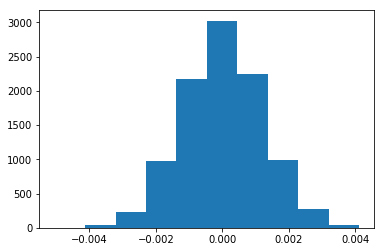

In [27]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [46]:
act_diff = df2[df2['group']=="treatment"]["converted"].mean()-df2[df2['group']=="control"]["converted"].mean()
(p_diffs > act_diff).mean()

0.90780000000000005

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Part j has the p value which is the probability of the value occuring if null hypothesis was true. The high p value  indicates that the new page is not much better than old page. We fail to reject the null hypothesis**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [34]:
import statsmodels.api as sm

convert_old = df2.query("landing_page == 'old_page' and converted == 1").shape[0]
convert_new = df2.query("landing_page == 'new_page' and converted == 1").shape[0]
n_old = df2.query('group == "control"').shape[0]
n_new = df2.query('group == "treatment"').shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [47]:
z_score,p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new],alternative = "smaller")
print(z_score, p_value)

1.31092419842 0.905058312759


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

** This means that the conversion rates for the old and new page are not much different. Thus, we fail to reject the null hypothesis. Yes the results agree **

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

** We could use logistic regression since the response variable has just 2 levels**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a colun for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [37]:
df2['intercept']=1
# use get_dummies for categorical variables, since the output columns are in alphabetical order
df2[['other_page','ab_page']]= pd.get_dummies(df2['group'])

c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [32]:
import statsmodels.api as sm

In [38]:
logmod = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
results = logmod.fit()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [39]:
from scipy import stats
stats.chisqprob = lambda chisq, df2: stats.chi2.sf(chisq, df2)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 29 Jan 2018   Pseudo R-squ.:               8.077e-06
Time:                        10:08:14   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br> 

**p-value obtained for ab_page being significant is for a 2 tailed test, for a one tailed test let us divide the value by 2 thus p value in this is 0.095. This value is a little different from that computed in previos section. This is because the null hypothesis in this is that ab_page that is the treatment page is highly related to the conversion rate. In the earlier analysis the null hypothesis was that the old page was equal or better than the new page**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Other factors that might influence whether or not an individual converts could be the initial objective of the person when he logs on, the culture and preference of individual. Disadvantages to adding additional terms might be the simpson;s paradox and multicollinearity issue.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - Provide the statistical output as well as a written response to answer this question.

In [41]:
df3=pd.read_csv('countries.csv')
print(df3['country'].unique())

['UK' 'US' 'CA']


In [42]:
# join the datasets and then check the resulting dataframe
df2 = df2.join(df3.set_index('user_id'), on='user_id')
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [43]:
# convert the categorical variable to quantitative using dummy variables
df2[['CA','UK','US']]= pd.get_dummies(df2['country'])
# consider US as the baseline and create a logistic regression model
logmod = sm.Logit(df2['converted'],df2[['intercept','ab_page','CA','UK']])
results = logmod.fit()
from scipy import stats
stats.chisqprob = lambda chisq, df2: stats.chi2.sf(chisq, df2)
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 29 Jan 2018   Pseudo R-squ.:               2.323e-05
Time:                        10:09:49   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

In [44]:
1/np.exp(-0.0408),np.exp(0.0099)

(1.0416437559600236, 1.0099491671175422)

From the coefficients of CA and UK countries in the regression models and the high p value, we find that conversion rate does not change much based on the country of the person.